In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import pandas as pd
import tensorflow as tf
from tqdm import tqdm , tqdm_notebook
import numpy as np
import category_encoders as ce
import re
from copy import deepcopy
from MI import Gene_Missing
import matplotlib.pyplot as plt
import warnings , sys
warnings.filterwarnings('ignore')
sys.path.append('/home/advice/Python/SR/Custom/')
from utility import *
from Activations import *
from pyprnt import prnt as PrettyPrint


# autoimpute imports - imputations & analysis
from autoimpute.imputations import MultipleImputer


    사용하면 좋은 패키지
    st / train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RAW_ = pd.read_csv("/home/advice/Python/SR/Data/bank.csv", sep = ",")
usecols = RAW_.columns.tolist()
print(RAW_.shape)
print(RAW_.dropna().shape)
#RAW_ = RAW_.dropna().reset_index(drop=True)
RAW_.head()

(4521, 17)
(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# for col in objcols :
#     print("{} : {}".format(col , RAW_[col].nunique()))

In [4]:
st(RAW_)

<class 'pandas.core.frame.DataFrame'> : dimension of (4521, 17)
Index: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ...  : int64 

age         int64  [[30, 33, 35, 59, 36, 39, 41, 43, 20, 31, 40, ...
job        object  [[unemployed, services, management, blue-colla...
marital    object                      [[married, single, divorced]]
education  object          [[primary, secondary, tertiary, unknown]]
default    object                                        [[no, yes]]
balance     int64  [[1787, 4789, 1350, 1476, 0, 747, 307, 147, 22...
housing    object                                        [[no, yes]]
loan       object                                        [[no, yes]]
contact    object                   [[cellular, unknown, telephone]]
day         int64  [[19, 11, 16, 3, 5, 23, 14, 6, 17, 20, 13, 30,...
month      object    [[oct, may, apr, jun, feb, aug, jan, jul, nov]]
duration    int64  [[79, 220, 185, 199, 226, 141, 341, 151, 57, 3...
campaign    int64                           [[1, 4, 2, 5,

In [5]:
print(RAW_.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [6]:
RAW = RAW_.copy()
RAW.shape

(4521, 17)

In [7]:
RAW.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [8]:
# category = ["SEX" , "EDUCATION" , "MARRIAGE" ,
#             'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6', 'default payment next month']
# RAW[category] = RAW[category].astype(str)

In [9]:

obj_col = RAW.select_dtypes("object").columns.tolist()
ord_col = RAW.select_dtypes("int").columns.tolist()
num_col = RAW.select_dtypes("float").columns.tolist()
print(obj_col)
assert len(usecols) == len(obj_col + ord_col + num_col)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [10]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(-1,1))
minmax.feature_range

(-1, 1)

## Missing 관련 정보 정리하기

In [11]:
%load_ext autoreload
%autoreload 2
from MissInfo import MissInfo
missinfo = MissInfo(RAW , obj_col , num_col , ord_col , minmax)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
minmax.feature_range

(-1, 1)

In [13]:
p_miss = 0.05

missinfo.fit()
trainX , testX , trainM , testM = missinfo.DL_train_test_split(0.7 , p_miss= p_miss ,
                                                               smooth = True , 
                                                               numpy= True)

Missing 정보 함축
53


In [14]:
miss_info = missinfo.information()
print(list(miss_info.keys()))

['X', 'original_column', 'scaler', 'obj_col', 'ord_col', 'num_col', 'ce_replace', 'obj_idx', 'ord_idx', 'ce_encoder', 'columns', 'obj_info', 'obj_range', 'cat_num_idx_info', 'obj_weight_info', 'ori_missing_matrix', 'ori_transform_missing_matrix', 'ori_raw_pd', 'ori_transform_pd']


In [15]:
missing_sum = pd.DataFrame([np.sum(trainM , axis = 0) , np.sum(testM, axis = 0)])
m = pd.concat([missing_sum,pd.DataFrame(missing_sum.sum()).T]).T
m.columns = ["train","test", "sum"]
m["total"] = RAW.shape[0]
m["missing rate"] =np.round(m["sum"] / m["total"] * 100  , 2 )
m = m.T
m

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
train,158.00,154.00,154.00,154.00,154.00,154.00,154.00,154.00,154.00,154.00,...,144.00,163.00,178.00,150.00,179.00,179.00,179.00,179.00,179.00,179.00
test,69.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,85.00,...,59.00,71.00,72.00,51.00,69.00,69.00,69.00,69.00,69.00,69.00
sum,227.00,239.00,239.00,239.00,239.00,239.00,239.00,239.00,239.00,239.00,...,203.00,234.00,250.00,201.00,248.00,248.00,248.00,248.00,248.00,248.00
total,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,...,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00,4521.00
missing rate,5.02,5.29,5.29,5.29,5.29,5.29,5.29,5.29,5.29,5.29,...,4.49,5.18,5.53,4.45,5.49,5.49,5.49,5.49,5.49,5.49


In [16]:
miss_info = missinfo.information()
print(list(miss_info.keys()))

['X', 'original_column', 'scaler', 'obj_col', 'ord_col', 'num_col', 'ce_replace', 'obj_idx', 'ord_idx', 'ce_encoder', 'columns', 'obj_info', 'obj_range', 'cat_num_idx_info', 'obj_weight_info', 'ori_missing_matrix', 'ori_transform_missing_matrix', 'ori_raw_pd', 'ori_transform_pd']


In [17]:
missinfo.info["obj_info"]

{'job': {'start_idx': 1, 'n': 12},
 'marital': {'start_idx': 13, 'n': 3},
 'education': {'start_idx': 16, 'n': 4},
 'default': {'start_idx': 20, 'n': 2},
 'housing': {'start_idx': 23, 'n': 2},
 'loan': {'start_idx': 25, 'n': 2},
 'contact': {'start_idx': 27, 'n': 3},
 'month': {'start_idx': 31, 'n': 12},
 'poutcome': {'start_idx': 47, 'n': 4},
 'y': {'start_idx': 51, 'n': 2}}

In [18]:
ck = missinfo.ori_missing[0,:].astype(bool)
missinfo.ori_raw_pd.loc[:,ck].head(1)

,duration
0,-0.950348


In [19]:
ck = missinfo.ori_transform_missing[0,:].astype(bool)
missinfo.ori_transform_pd.loc[:,ck].head(1)

,duration
0,-0.950348


In [20]:
%load_ext autoreload
%autoreload 2
from Tensorflow_GainMI import Missing_GAIN as MG
from Tensorflow_AutoEncMI import Missing_AE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
missinfo.ori_transform_pd.shape

(4521, 53)

In [22]:
len(miss_info["cat_num_idx_info"])

17

In [23]:
len(miss_info["original_column"])

17

In [24]:
Auto = Missing_AE(enc_dim = [35 , 30 , 20 , 20 , 15]  , dec_dim= [20,25,35,35, 45] ,
                  missing_info = miss_info , 
                  save_info_path = "./Bank_AE_missinfo_{}.pkl".format(p_miss) , 
                  save_model_path= './Bank_CAT_AE_{}/Model'.format(p_miss)  ,
                  gpu = 1) 
mb_size = 512
Auto.fit(trainX , trainM ,testX , testM , 
         mb_size , 
         epoch = 10000,
         Enc_act = tf_mish , 
         Dec_act = tf_mish ,
         weight_regularizer = 0,
         SN= False ,  lr = 0.005 ,
         patience = 10 ,
         cutoff = 1e-20 ,
         MetricLoss = False , 
        )

./Bank_AE_missinfo_0.05.pkl에 missing info 저장
Instructions for updating:
Colocations handled automatically by placer.
Onehot Shape : [53] --> Embedding Shape : [41] 
Input Shape : (?, 41)
Instructions for updating:
Use tf.cast instead.
                        모델피팅                        


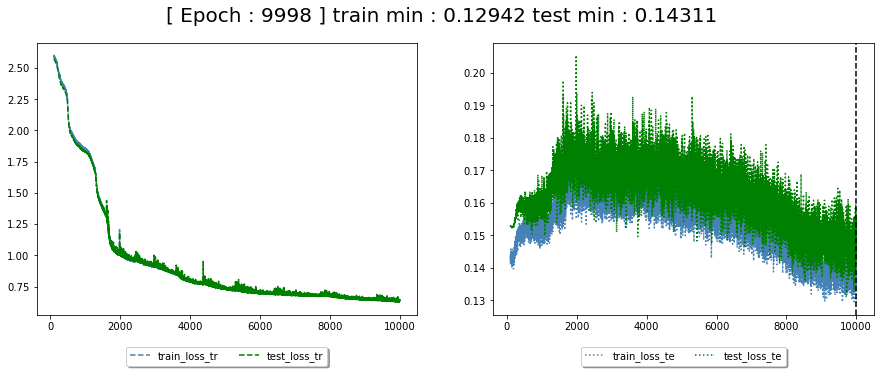

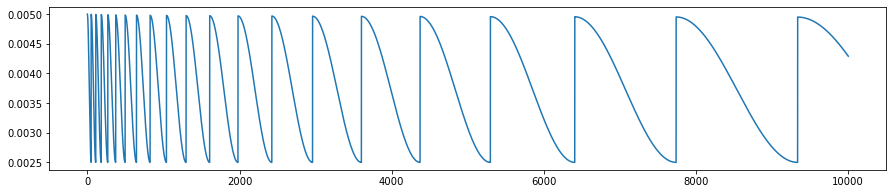

      학습완료 


In [25]:
Auto.train()

In [26]:
mg = MG(gen_dim = [100, 90, 75 , 65 , 55 ]  , 
        dis_dim = [100, 90, 75 , 65 , 55 ] , 
        missing_info = miss_info , 
        save_info_path= "./Bank_GAIN_info_{}.pkl".format(p_miss),
        save_model_path= './Bank_CAT_GAIN_{}/Model'.format(p_miss),
        gpu = 0 , )
mb_size = 256
mg.fit(trainX , trainM ,testX , testM , mb_size , 
       hint = 0.9 ,
       Gact = tf_mish , 
       Dact = tf.nn.selu , 
       epoch = 10000, 
       alpha = 3.0 , 
       weight_regularizer = 0 ,
       SN = False ,
       max_norm = False , 
       lr = 0.002 , 
       patience = 20 ,
       cutoff = 1e-20
      )

./Bank_GAIN_info_0.05.pkl에 missing info 저장

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Columns : age                       | mse        | [1]
Instructions for updating:
Use tf.cast instead.


2019-11-15 22:43:37 | From /root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Columns : job                       | multiclass | [12]
Columns : marital                   | multiclass | [3]
Columns : education                 | multiclass | [4]
Columns : default                   | binary     | [2]
Columns : balance                   | mse        | [1]
Columns : housing                   | binary     | [2]
Columns : loan                      | binary     | [2]
Columns : contact                   | multiclass | [3]
Columns : day                       | mse        | [1]
Columns : month                     | multiclass | [12]
Columns : duration                  | mse        | [1]
Columns : campaign                  | mse        | [1]
Columns : pdays                     | mse        | [1]
Columns : previous                  | mse        | [1]
Columns : poutcome                  | multiclass | [4]
Columns : y                         | binary     | [2]
                        모델피팅                        


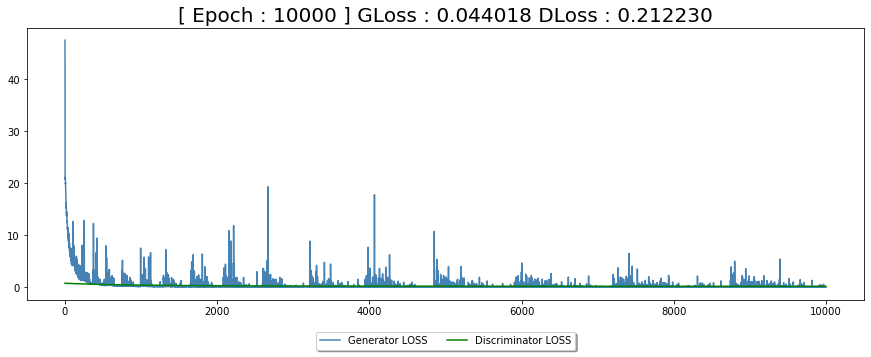

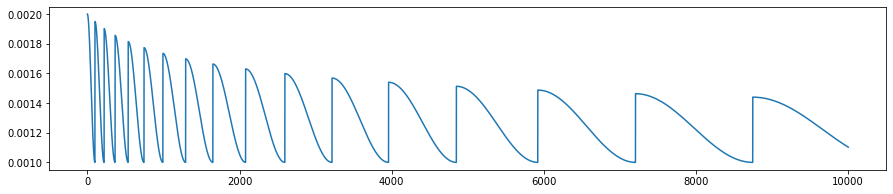

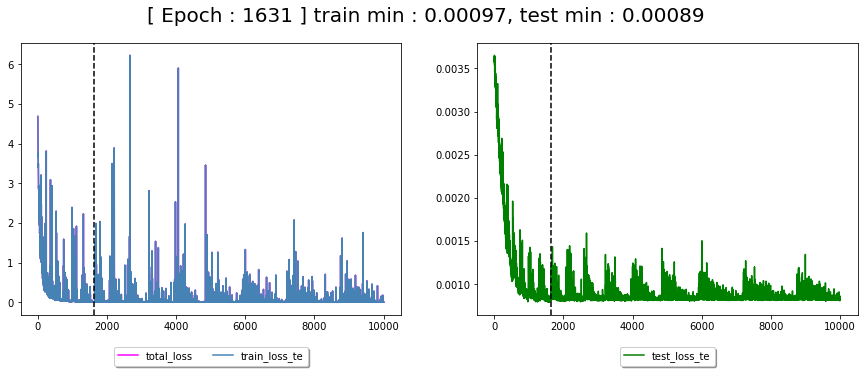

      학습완료 


In [27]:
mg.train()

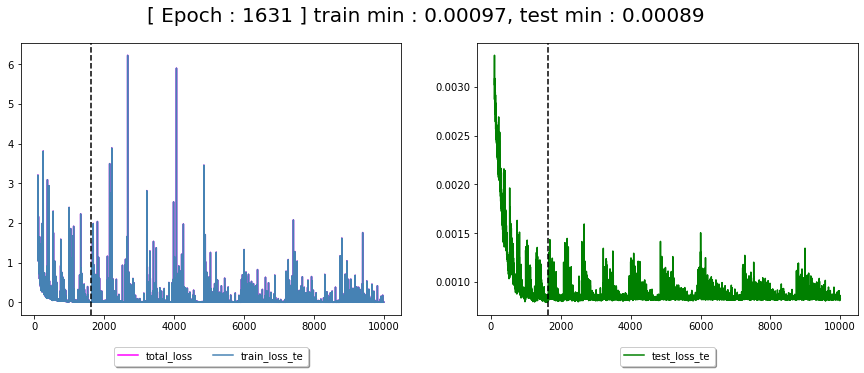

In [28]:
mg.metric_plot(idx = 100)

In [29]:
missing_matrix_RAW = miss_info["ori_transform_missing_matrix"]
missing_RAW = miss_info["ori_transform_pd"]
missing_matrix_ori_RAW = miss_info["ori_missing_matrix"]
missing_data = deepcopy(missing_RAW.values)
missing_data[missing_matrix_RAW == 1] = np.nan

In [30]:
pd.DataFrame(missing_data , columns= miss_info["columns"]).head(2)

,age,job_unemployed,job_services,job_management,job_blue-collar,job_self-employed,job_technician,job_entrepreneur,job_admin.,job_student,...,duration,campaign,pdays,previous,poutcome_unknown,poutcome_failure,poutcome_other,poutcome_success,y_no,y_yes
0,-0.676471,0.499598,0.072887,0.070014,0.089160,0.014786,0.016171,0.030392,0.019371,0.049156,...,NaN,-1.0,-1.000000,-1.0,0.730401,0.140774,0.081831,0.046994,0.948934,0.051066
1,-0.588235,0.051315,0.542716,0.043132,0.047925,0.051272,0.018397,0.007431,0.045212,0.063495,...,-0.857001,-1.0,-0.220183,NaN,NaN,NaN,NaN,NaN,0.955694,0.044306


In [31]:
missing_matrix_RAW

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
AE_load_data = Auto.load_impute(save_file = './Bank_CAT_AE_{}/Model.meta'.format(p_miss) , 
                 file= "./Bank_CAT_AE_{}/".format(p_miss) ,
                 Data = missing_data , 
                 Missing = missing_matrix_RAW
                )

Instructions for updating:
Use standard file APIs to check for files with this prefix.


| 2019-11-16 03:03:29 | From /root/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./Bank_CAT_AE_0.05/Model


| 2019-11-16 03:03:29 | Restoring parameters from ./Bank_CAT_AE_0.05/Model


In [33]:
MG_load_data = mg.load_impute(
    save_file = './Bank_CAT_GAIN_{}/Model.meta'.format(p_miss) , 
                 file= "./Bank_CAT_GAIN_{}/".format(p_miss)  ,
                 Data = missing_data , 
                 Missing = missing_matrix_RAW
                )

INFO:tensorflow:Restoring parameters from ./Bank_CAT_GAIN_0.05/Model


| 2019-11-16 03:04:01 | Restoring parameters from ./Bank_CAT_GAIN_0.05/Model


In [34]:
RAW_TRANS = Auto.transform(missing_RAW.values , num_inv_scaler= True)

| 2019-11-16 03:05:02 | findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
| 2019-11-16 03:05:02 | findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
| 2019-11-

| 2019-11-16 03:05:02 | findfont: score(<Font 'Purisa' (Purisa.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXGeneral' (STIXGeneral-Italic.otf) italic normal 400 normal>) = 11.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Regular.otf) normal normal regular normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXIntegralsSm' (STIXIntegralsSm-Regular.otf) normal normal regular normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'NanumBarunGothic' (NanumBarunGothic.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
| 2019-11-16 03:05:02 | findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal bold normal>) = 11.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal bold conde

| 2019-11-16 03:05:02 | findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
| 2019-11-16 03:05:02 | findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal bold condensed>) = 0.5349999999999999
| 2019-11-16 03:05:02 | findfont: score(<Font 'NanumMyeongjo' (NanumMyeongjoBold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Purisa' (Purisa-BoldOblique.ttf) oblique normal bold normal>) = 11.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'NanumGothic Eco' (NanumGothicEcoExtraBold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:0

| 2019-11-16 03:05:02 | findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXGeneral' (STIXGeneral-BoldItalic.otf) italic normal bold normal>) = 11.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
| 2019-11-16 03:05:02 | findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25
| 2019-11-16 03:05:02 | findfont: score(<Font 'STIXSizeThreeSym' (STIXSizeThreeSym-Bold.otf) normal normal bold normal>) = 10.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-BI.ttf) italic normal bold normal>) = 11.335
| 2019-11-16 03:05:02 | findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal medium normal>) = 10.145
| 2019-11-16 03:05:02 | fin

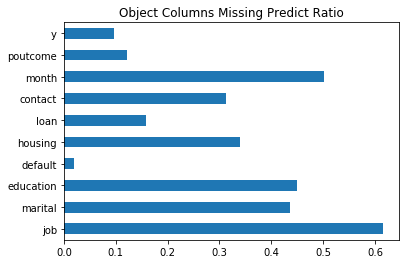

,N_not_correct,N_missing,PFC
job,147,239.0,0.615063
marital,110,252.0,0.436508
education,106,236.0,0.449153
default,5,246.0,0.020325
housing,82,241.0,0.340249
loan,39,246.0,0.158537
contact,69,221.0,0.312217
month,117,233.0,0.502146
poutcome,30,248.0,0.120968
y,24,248.0,0.096774


In [35]:
Auto.object_comparision(RAW_TRANS , AE_load_data)

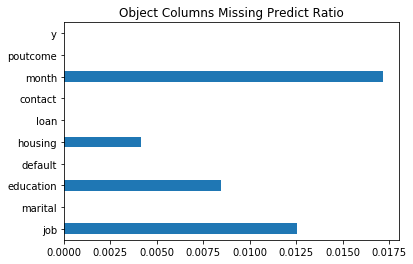

,N_not_correct,N_missing,PFC
job,3,239.0,0.012552
marital,0,252.0,0.000000
education,2,236.0,0.008475
default,0,246.0,0.000000
housing,1,241.0,0.004149
loan,0,246.0,0.000000
contact,0,221.0,0.000000
month,4,233.0,0.017167
poutcome,0,248.0,0.000000
y,0,248.0,0.000000


In [36]:
mg.object_comparision(RAW_TRANS , MG_load_data)

## Numerical 변수만 가지고 RMSE 비교

In [37]:
print("AutoEncoder  : " ,  Auto.metric(RAW_TRANS , AE_load_data , 
                                     missing_matrix_RAW , standardize = False ,
                                       metric_type ="rmse" , 
                                     kf = None ) )

AutoEncoder  :  89.53455197917273


In [38]:
print('GAIN : ' , mg.metric(RAW_TRANS , MG_load_data ,
                            missing_matrix_RAW , standardize = False,
                            metric_type ="rmse" , 
                            kf = None
                         )  )

GAIN :  22.297376546009197


In [39]:
cc = RAW_TRANS.columns.tolist()
missing = pd.DataFrame(missing_matrix_RAW, columns =  miss_info["columns"])
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)

In [40]:
from Imputation import Evaluate as EV
from sklearn.model_selection import KFold
kf = KFold(n_splits = 7) # Define the split - into 2 folds 
kf.get_n_splits(missing_data)
objcols = miss_info["obj_col"]
cc = RAW_TRANS.columns.tolist()
for col in RAW_TRANS.columns.tolist() :
    if col in obj_col :
        cc.remove(col)

raw = deepcopy(RAW_TRANS)
missing_matrix = deepcopy(missing_matrix_ori_RAW)
Imputation_BenchMark = EV(T = raw , 
                          kf = kf ,
                          mask= missing_matrix ,
                          obj = objcols ,
                          notobj = cc , 
                          target = "y" , 
                          miss_info= miss_info , 
                          algo =  ["MissForest","mean", "median" , 
                          "knn", "mode", "MICE"  , "EM" , ])

In [41]:
Imputation_BenchMark.evaluate(standardize = False )

MissForest 진행중....
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 1
Iteration: 1
Iteration: 1
Iteration: 1
Iteration: 1
Iteration: 1Iteration:
 1
Iteration: 2
Iteration: 2
Iteration: 2
Iteration: 2Iteration: 2

MissForest (646, 17)
MissForest (646, 17)
Iteration: 2
Iteration: 2
MissForest (646, 17)
Iteration: 3
Iteration: 3
Iteration: 3
MissForest (646, 17)
Iteration: 3
MissForest (645, 17)
Iteration: 4
Iteration: 4
Iteration: 5
MissForest (646, 17)
Iteration: 5
MissForest (646, 17)
MissForest | RMSE : 99.85794323424632 | NRMSE : 0.052209135050284454 | 97.145초
MissForest (4521, 17)
mean 진행중....
mean (646, 7)
meanmean (646, 7)
 (646, 7)
mean (646, 7)
mean (645, 7)
mean (646, 7)
mean (646, 7)
mean | RMSE : 89.89865971849348 | NRMSE : 0.04130921266313351 | 0.203초
mean (4521, 7)
median 진행중....
median (646, 7)
median (646, 7)
median (646, 7)
median (646, 7)
median (646, 7)
median (646, 7)
median (645, 7)
median | RMSE : 94.5990834257827

In [42]:
Imputation_BenchMark.append_algo(name ="GAIN", 
                                 rmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = mg.metric(RAW_TRANS , MG_load_data  ,
                                           missing_matrix_RAW, standardize = False, 
                                           kf = kf.split(missing_data) ,
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= MG_load_data)
Imputation_BenchMark.append_algo(name = "AutoEncoder", 
                                 rmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "rmse"
                                          ) , 
                                 nrmse = Auto.metric(RAW_TRANS , AE_load_data , 
                                           missing_matrix_RAW, standardize = False ,
                                           kf = kf.split(missing_data) , 
                                           metric_type = "nrmse"
                                          ) , 
                                 imputed= AE_load_data)

GAIN 업데이트
AutoEncoder 업데이트


In [43]:
Imputation_BenchMark.Outcome()

 가공 MissForest
 가공 mean Category Most Common Imputation
 가공 median Category Most Common Imputation
 가공 knn Category Most Common Imputation
 가공 mode Category Most Common Imputation
 가공 MICE
 가공 EM Category Most Common Imputation
 가공 GAIN
 가공 AutoEncoder


In [44]:
Imputation_BenchMark.Predict_Comparision()

MissForest , score : 0.88675
mean       , score : 0.88741
median     , score : 0.88786
knn        , score : 0.88675
mode       , score : 0.88786
MICE       , score : 0.88719
EM         , score : 0.88852
GAIN       , score : 0.88741
AutoEncoder, score : 0.88675


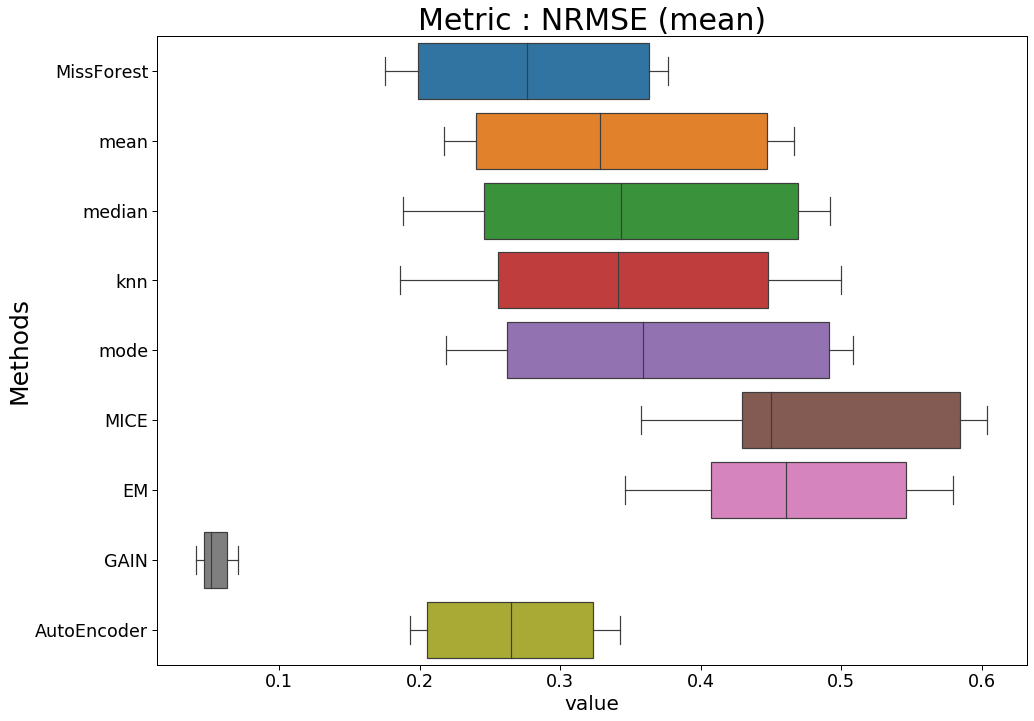

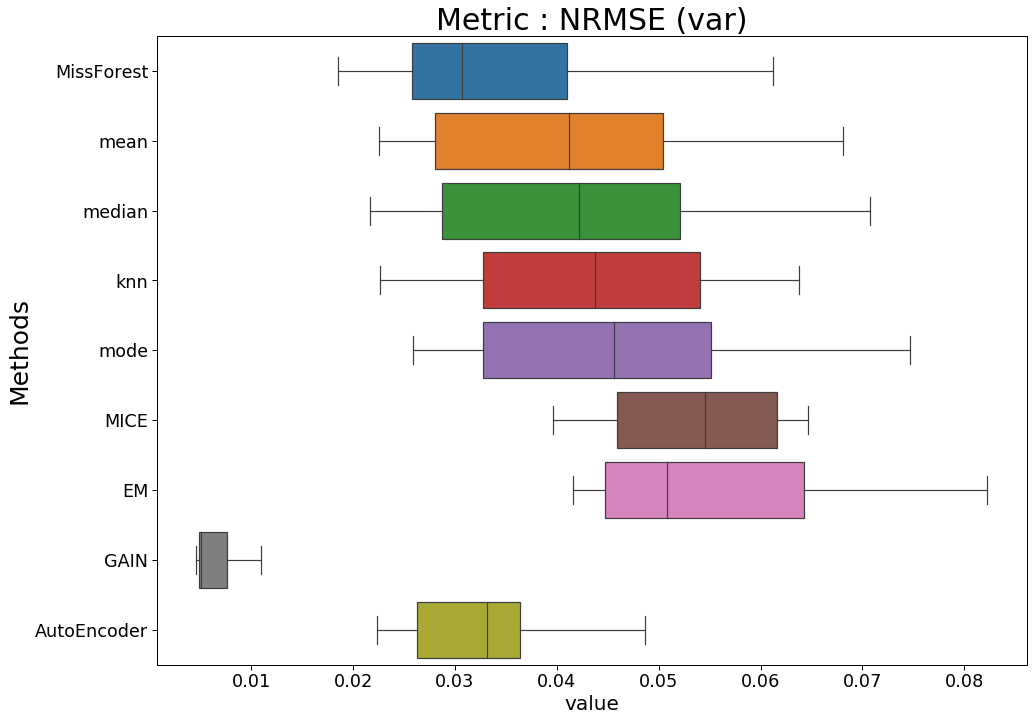

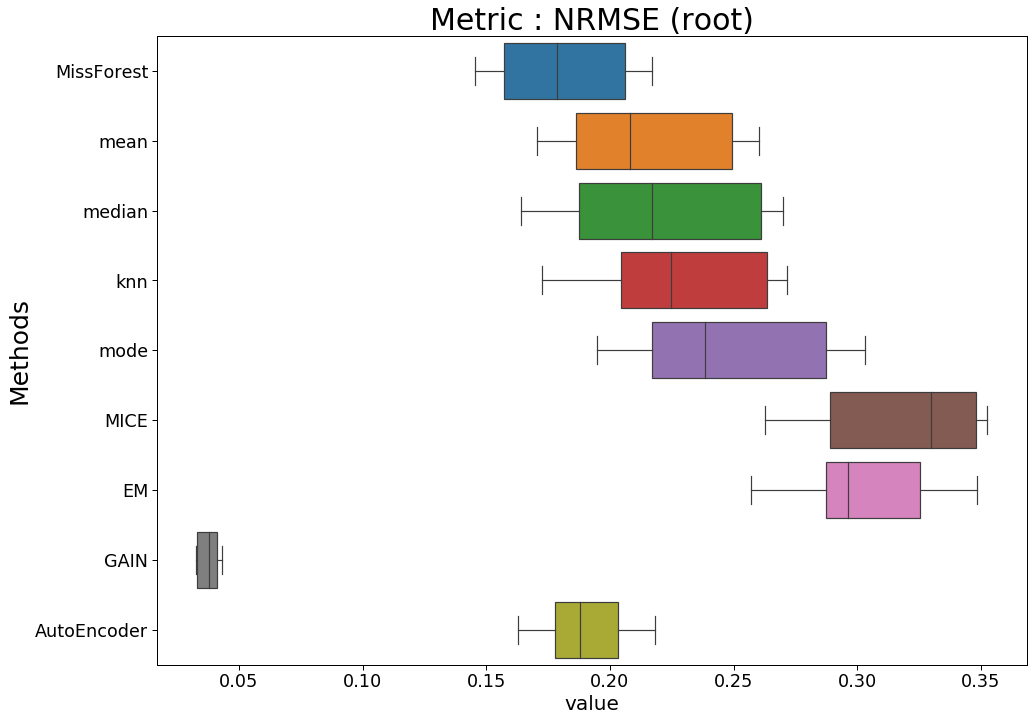

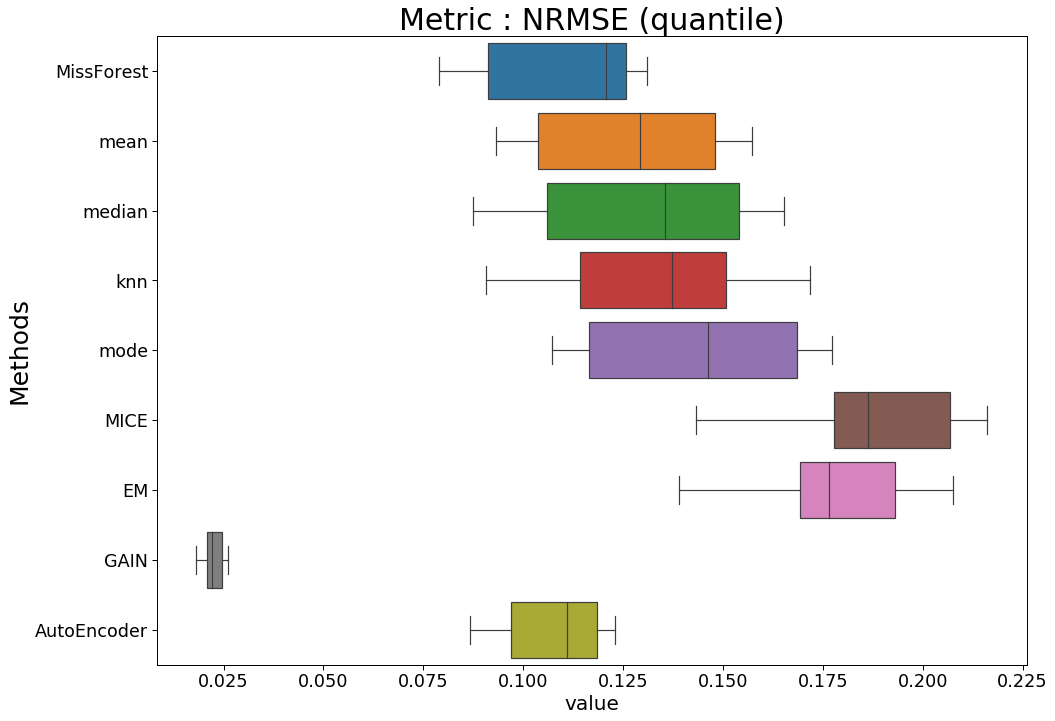

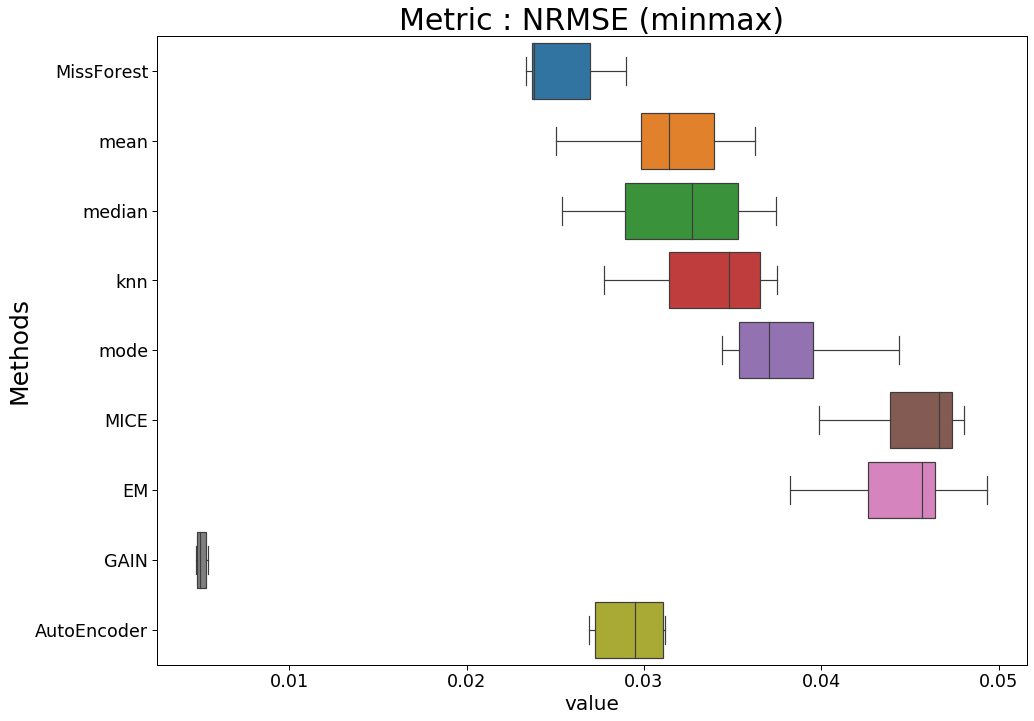

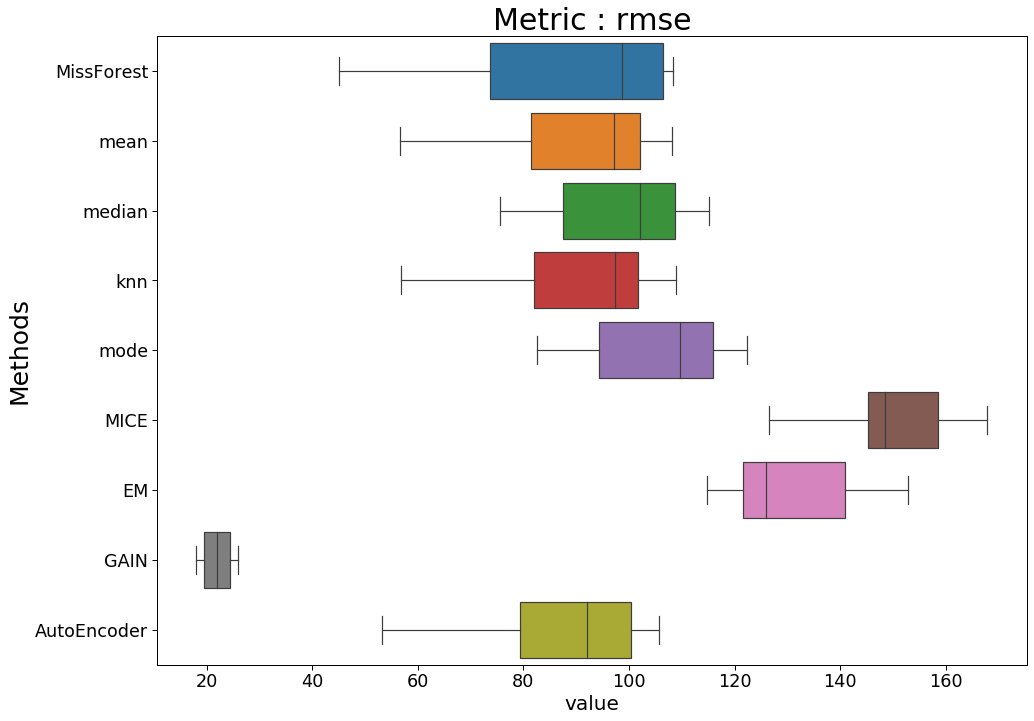

In [78]:
# from sklearn.metrics import f1_score , balanced_accuracy_score as bacc , accuracy_score 
# Imputation_BenchMark.Measure_Vis(balanced_accuracy_score)
Imputation_BenchMark.cv_boxplot_all_run(path="./Bank_Vis_{}".format(p_miss))

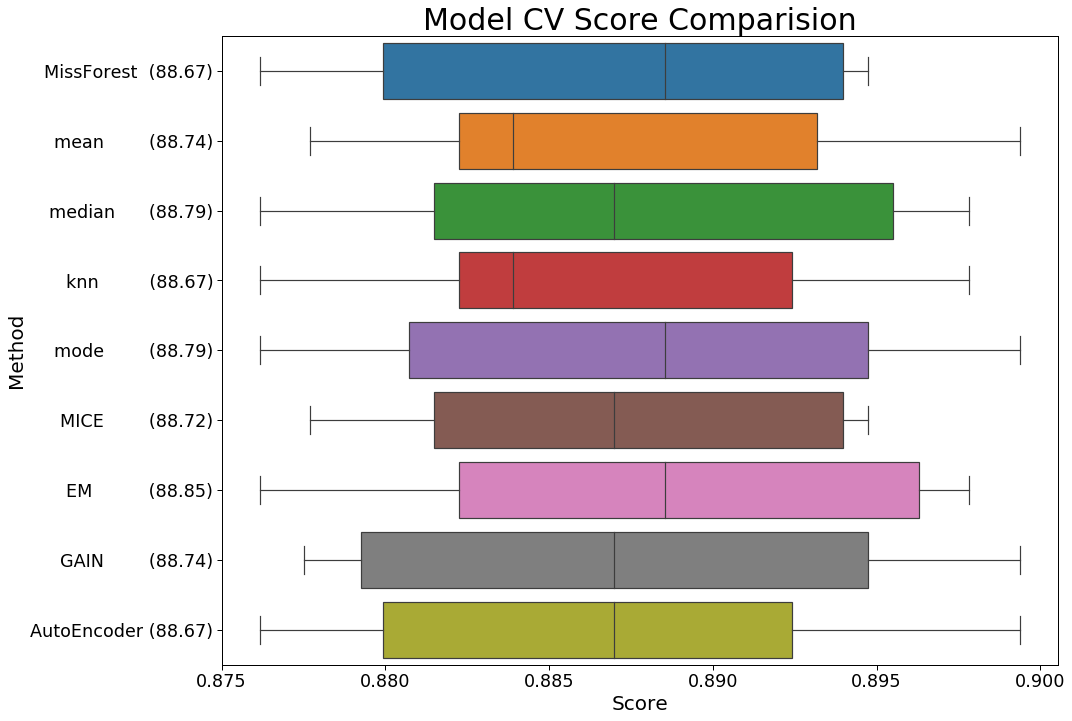

In [79]:
Imputation_BenchMark.Modeling_Measure_Vis(path =\
                                          "./Bank_Vis_{}/Bank_Models_Comparision.png".\
                                          format(p_miss))

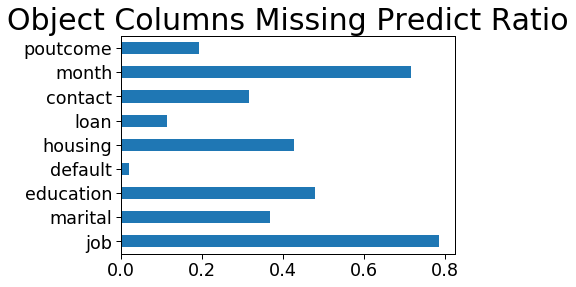

,N_not_correct,N_missing,PFC
job,188,239.0,0.786611
marital,93,252.0,0.369048
education,113,236.0,0.478814
default,5,246.0,0.020325
housing,103,241.0,0.427386
loan,28,246.0,0.113821
contact,70,221.0,0.316742
month,167,233.0,0.716738
poutcome,48,248.0,0.193548


In [64]:
Imputation_BenchMark.object_most_commom(None)

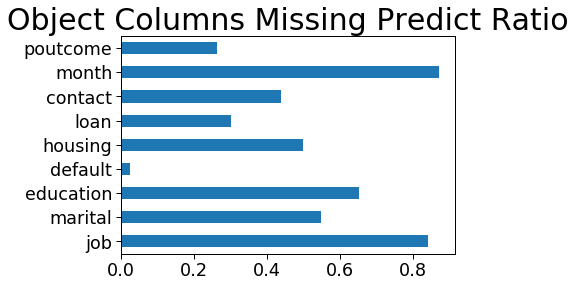

,N_not_correct,N_missing,PFC
job,201,239.0,0.841004
marital,138,252.0,0.547619
education,154,236.0,0.652542
default,6,246.0,0.024390
housing,120,241.0,0.497925
loan,74,246.0,0.300813
contact,97,221.0,0.438914
month,203,233.0,0.871245
poutcome,65,248.0,0.262097


In [74]:
# Imputation_BenchMark.MICE_object_comparison(None)
Imputation_BenchMark.objectType_comparision(name="MICE", save_file_path="./")

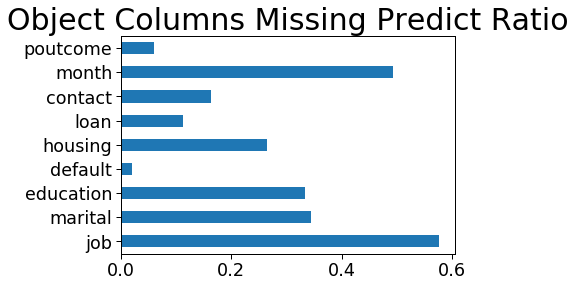

,N_not_correct,N_missing,PFC
job,138,239.0,0.577406
marital,87,252.0,0.345238
education,79,236.0,0.334746
default,5,246.0,0.020325
housing,64,241.0,0.265560
loan,28,246.0,0.113821
contact,36,221.0,0.162896
month,115,233.0,0.493562
poutcome,15,248.0,0.060484


In [66]:
Imputation_BenchMark.Missforest_object_comparision("./")

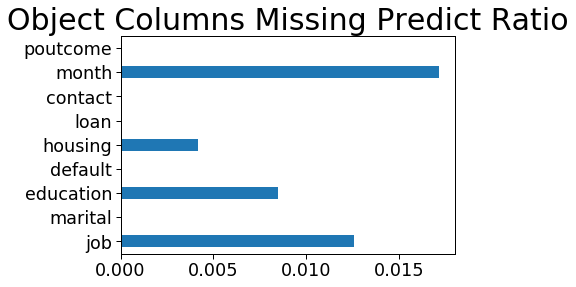

,N_not_correct,N_missing,PFC
job,3,239.0,0.012552
marital,0,252.0,0.000000
education,2,236.0,0.008475
default,0,246.0,0.000000
housing,1,241.0,0.004149
loan,0,246.0,0.000000
contact,0,221.0,0.000000
month,4,233.0,0.017167
poutcome,0,248.0,0.000000


In [67]:
mg.object_comparision(RAW_TRANS , MG_load_data, target = "y")

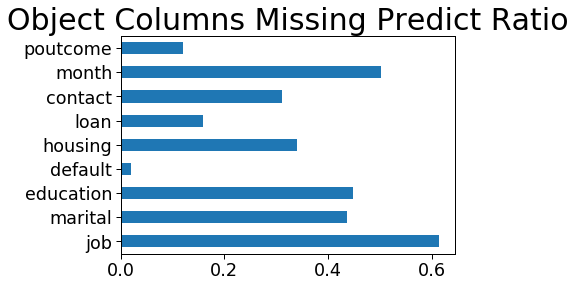

,N_not_correct,N_missing,PFC
job,147,239.0,0.615063
marital,110,252.0,0.436508
education,106,236.0,0.449153
default,5,246.0,0.020325
housing,82,241.0,0.340249
loan,39,246.0,0.158537
contact,69,221.0,0.312217
month,117,233.0,0.502146
poutcome,30,248.0,0.120968


In [68]:
Auto.object_comparision(RAW_TRANS , AE_load_data, target = "y")

In [70]:
Imputation_BenchMark.show_result( row_m= 4 , n = 3)

,algo,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,missing,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0
1,missing,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,missing,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1
3,True,33,,,,,0,,no,,0,,0,1,122,0,failure,
4,True,43,unknown,,,,1937,,no,,0,,0,0,-0,0,,no
5,True,0,,,,,0,,,,0,apr,457,1,0,0,success,yes
6,MissForest,32.9085,,,,,0,,no,,0,,0,2.74573,168.517,0,failure,
7,MissForest,44.0419,management,,,,1241.96,,no,,0,,0,0,-0,0,,no
8,MissForest,0,,,,,0,,,,0,aug,198.952,2.56664,0,0,failure,yes
9,mean,41.1338,,,,,0,,no,,0,,0,2.88599,41.5349,0,unknown,


In [54]:
Imputation_BenchMark.save_result("./Bank_Vis_{}/Bank_Info.pkl".format(p_miss))

## Category 변수와 같이 학습을 시키면 Numeric 변수의 성능이 떨어진다....
 

In [ ]:
# Imputation_BenchMark.save_result("./BenckMark_Bank_result")
# Imputation_BenchMark.plot(figsize = (10 , 9) , 
#                           metric = "rmse" ,
#                           img_name="./BenchMark_Bank.png")

In [ ]:
# Imputation_BenchMark.save_result("./BenckMark_Bank_result")
# Imputation_BenchMark.plot(figsize = (10 , 9) , 
#                           metric = "nrmse" ,
#                           img_name="./BenchMark_Bank.png")

In [ ]:
# Imputation_BenchMark.re_metric(mode = "standardize" )
# Imputation_BenchMark.plot(figsize = (10 , 9) , img_name="./BenchMark_Bank.png")
# Imputation_BenchMark.re_metric(mode = "inverse" )
# Imputation_BenchMark.plot(figsize = (10 , 9) , img_name="./BenchMark_Bank_inverse.png")